In [27]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Get data from NYC OpenData API

In [10]:
# get NYPD complaint data from NYC's OpenData portal and store in df

# set URL params so that API will only return dates in 2022 and will not hit a row limit
start_date = "2022-01-01"
end_date = "2023-01-01"
limit = 5000000

crime_data_url = (
    f"https://data.cityofnewyork.us/resource/qgea-i56i.csv?"
    f"$limit={limit}&"
    f"$where=cmplnt_fr_dt%20BETWEEN%20%27{start_date}T00:00:00%27%20AND%20%27{end_date}T00:00:00%27" 
)

crime_data = pd.read_csv(crime_data_url)

crime_data.head()

,cmplnt_num,cmplnt_fr_dt,cmplnt_fr_tm,cmplnt_to_dt,cmplnt_to_tm,addr_pct_cd,rpt_dt,ky_cd,ofns_desc,pd_cd,...,susp_sex,transit_district,latitude,longitude,lat_lon,patrol_boro,station_name,vic_age_group,vic_race,vic_sex
0,261162330,2022-12-02T00:00:00.000,08:00:00,2022-12-30T00:00:00.000,14:00:00,122.0,2022-12-31T00:00:00.000,109,GRAND LARCENY,439.0,...,U,NaN,40.584770,-74.092488,"(40.58477, -74.092488)",PATROL BORO STATEN ISLAND,(null),45-64,WHITE,M
1,261170525,2022-11-01T00:00:00.000,15:00:00,2022-11-01T00:00:00.000,15:15:00,62.0,2022-12-31T00:00:00.000,578,HARRASSMENT 2,638.0,...,M,NaN,40.621708,-74.000593,"(40.621708, -74.000593)",PATROL BORO BKLYN SOUTH,(null),25-44,WHITE,F
2,261170526,2022-10-01T00:00:00.000,01:00:00,2022-12-31T00:00:00.000,13:10:00,62.0,2022-12-31T00:00:00.000,578,HARRASSMENT 2,638.0,...,M,NaN,40.621708,-74.000593,"(40.621708, -74.000593)",PATROL BORO BKLYN SOUTH,(null),25-44,WHITE,F
3,261175482,2022-10-04T00:00:00.000,05:30:00,2022-10-04T00:00:00.000,17:00:00,42.0,2022-12-31T00:00:00.000,109,GRAND LARCENY,439.0,...,(null),NaN,40.825003,-73.914132,"(40.825003, -73.914132)",PATROL BORO BRONX,(null),45-64,BLACK,F
4,261178126,2022-11-08T00:00:00.000,13:19:00,NaN,(null),106.0,2022-12-31T00:00:00.000,109,GRAND LARCENY,439.0,...,U,NaN,40.667921,-73.811064,"(40.667921, -73.811064)",PATROL BORO QUEENS SOUTH,(null),25-44,ASIAN / PACIFIC ISLANDER,M


# Initial data cleaning
1. combine date column and time column into one column
2. select only relevant columns
3. rename columns into more readable names


In [11]:
# combine date and time columns into one column
crime_data['timestamp'] = pd.to_datetime(crime_data['cmplnt_fr_dt'] + ' ' + crime_data['cmplnt_fr_tm'])

# select relevant columns showing the unique ID, location, time, and type of crime
crime_data = crime_data[["cmplnt_num", "latitude", "longitude", "ofns_desc", "timestamp"]]

# rename columns for readability
crime_data = crime_data.rename(
    columns={
        "cmplnt_num": "id", 
        "ofns_desc": "offense"
    }
)

crime_data.head()

,id,latitude,longitude,offense,timestamp
0,261162330,40.584770,-74.092488,GRAND LARCENY,2022-12-02 08:00:00
1,261170525,40.621708,-74.000593,HARRASSMENT 2,2022-11-01 15:00:00
2,261170526,40.621708,-74.000593,HARRASSMENT 2,2022-10-01 01:00:00
3,261175482,40.825003,-73.914132,GRAND LARCENY,2022-10-04 05:30:00
4,261178126,40.667921,-73.811064,GRAND LARCENY,2022-11-08 13:19:00


# Descriptive Analysis
Evaluate the validity of the data by checking:
1. Uniqueness of IDs
2. Distribution of offense types
3. Trend over time
4. That latitude and longitudes fall within NYC

In [74]:
# check that IDs are unique by comparing the total row count against the number of unique IDs
crime_data_len = len(crime_data)
unique_ids = len(crime_data["id"].unique())

crime_data_len == unique_ids


True

IDs are unique, so there is no deduplication or other cleaning needed for that field

<Axes: xlabel='offense_group'>

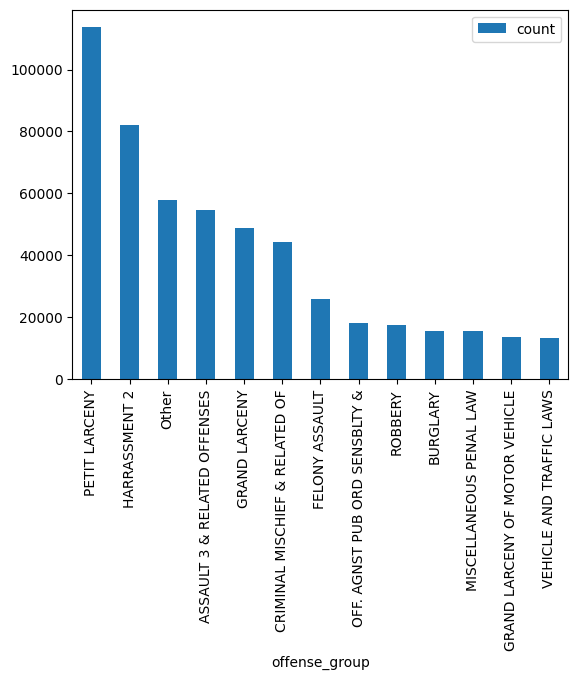

In [46]:
# visualize the number of crimes by offense
offenses_count = crime_data[["id", "offense"]] \
    .groupby(by=["offense"]) \
    .count() \
    .sort_values("id", ascending=False) \
    .reset_index()

offenses_count["offense_group"] = np.where(offenses_count["id"] >= 10000, offenses_count["offense"], "Other")

offenses_count[["id", "offense_group"]] \
    .groupby(by=["offense_group"]) \
    .sum() \
    .sort_values("id", ascending=False) \
    .rename(
        columns={
            "id": "count"
        }
    ) \
    .plot.bar()


Distribution of crimes looks reasonable - Petit Larceny (theft of <$1,000; typically shoplifting) is the most common.

<Axes: xlabel='month'>

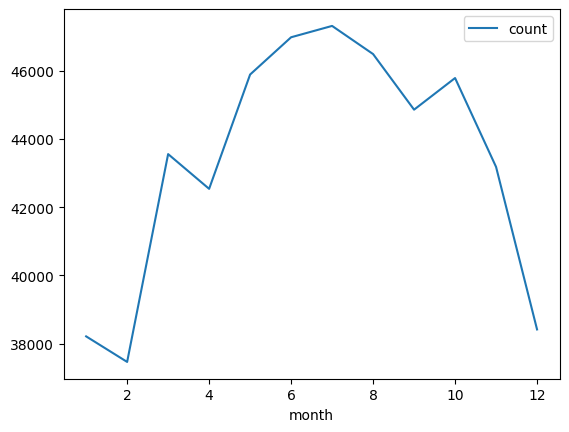

In [58]:
# add month
crime_data["month"] = pd.DatetimeIndex(crime_data["timestamp"]).month


crime_data[["month", "id"]] \
    .groupby(by=["month"]) \
    .count() \
    .sort_values("month", ascending=False) \
    .rename(
        columns={
            "id": "count"
        }
    ) \
    .plot.line()

Crime peaks in the summer and drops off in the winter, which is consistent with expectations

<Axes: xlabel='longitude', ylabel='latitude'>

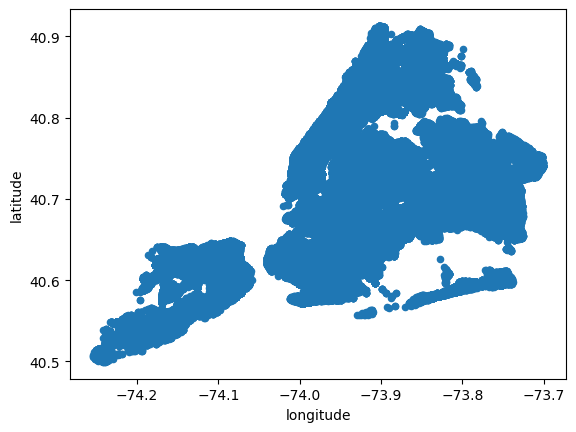

In [63]:
crime_data.plot(x="longitude", y="latitude", kind="scatter")

In [64]:
crime_data.describe()

,latitude,longitude,timestamp,chars,month
count,520658.000000,520658.000000,520661,520661.000000,520661.000000
mean,40.736987,-73.924438,2022-07-04 01:06:38.738334464,17.837870,6.579640
min,40.499393,-74.254741,2022-01-01 00:00:00,4.000000,1.000000
25%,40.676483,-73.974555,2022-04-08 15:00:00,13.000000,4.000000
50%,40.734955,-73.927388,2022-07-04 17:15:00,13.000000,7.000000
75%,40.810352,-73.880561,2022-09-29 03:54:00,28.000000,9.000000
max,40.912714,-73.700286,2022-12-31 23:55:00,36.000000,12.000000
std,0.081792,0.076995,NaN,7.752101,3.343381


Visually, it appears that all datapoints fall within NYC, and the max/min latitude and longitude make sense for the city.

From the `describe`, we can see that there are some unpopulated latitude/longitude values (count of latitude and longitude is 3 lower than other columns). We should exclude those records.

In [86]:
# remove null latitude/longitude
crime_data = crime_data[(crime_data["latitude"].notna() & crime_data["longitude"].notna())]

crime_data.describe()

,latitude,longitude,timestamp,chars,month
count,520658.000000,520658.000000,520658,520658.000000,520658.000000
mean,40.736987,-73.924438,2022-07-04 01:06:03.815672320,17.837794,6.579626
min,40.499393,-74.254741,2022-01-01 00:00:00,4.000000,1.000000
25%,40.676483,-73.974555,2022-04-08 15:00:00,13.000000,4.000000
50%,40.734955,-73.927388,2022-07-04 17:15:00,13.000000,7.000000
75%,40.810352,-73.880561,2022-09-29 03:57:45,28.000000,9.000000
max,40.912714,-73.700286,2022-12-31 23:55:00,36.000000,12.000000
std,0.081792,0.076995,NaN,7.752059,3.343385


# Add accessory columns
Adding a column to categorize the offense as a violent or non-violent crime since we may want to focus only on violent crimes in our final analysis.

In [87]:
# List all offense descriptions
sorted(crime_data["offense"].unique())

['(null)',
 'ADMINISTRATIVE CODE',
 'AGRICULTURE & MRKTS LAW-UNCLASSIFIED',
 'ALCOHOLIC BEVERAGE CONTROL LAW',
 'ANTICIPATORY OFFENSES',
 'ARSON',
 'ASSAULT 3 & RELATED OFFENSES',
 "BURGLAR'S TOOLS",
 'BURGLARY',
 'CANNABIS RELATED OFFENSES',
 'CHILD ABANDONMENT/NON SUPPORT',
 'CRIMINAL MISCHIEF & RELATED OF',
 'CRIMINAL TRESPASS',
 'DANGEROUS DRUGS',
 'DANGEROUS WEAPONS',
 'DISORDERLY CONDUCT',
 'DISRUPTION OF A RELIGIOUS SERV',
 'ENDAN WELFARE INCOMP',
 'ESCAPE 3',
 'FELONY ASSAULT',
 'FELONY SEX CRIMES',
 'FORGERY',
 'FRAUDS',
 'FRAUDULENT ACCOSTING',
 'GAMBLING',
 'GRAND LARCENY',
 'GRAND LARCENY OF MOTOR VEHICLE',
 'HARRASSMENT 2',
 'HOMICIDE-NEGLIGENT,UNCLASSIFIE',
 'HOMICIDE-NEGLIGENT-VEHICLE',
 'INTOXICATED & IMPAIRED DRIVING',
 'INTOXICATED/IMPAIRED DRIVING',
 'JOSTLING',
 'KIDNAPPING',
 'KIDNAPPING & RELATED OFFENSES',
 'LOITERING/GAMBLING (CARDS, DIC',
 'MISCELLANEOUS PENAL LAW',
 'MURDER & NON-NEGL. MANSLAUGHTER',
 'NEW YORK CITY HEALTH CODE',
 'NYS LAWS-UNCLASSIFIED FELONY

In [67]:
# define violent crimes as murder, assault, rape and sex crimes, and harassment 2 (includes striking/shoving/etc.)
violent_crimes = [
     'ASSAULT 3 & RELATED OFFENSES',
     'FELONY ASSAULT',
     'FELONY SEX CRIMES',
     'HARRASSMENT 2',
     'MURDER & NON-NEGL. MANSLAUGHTER',
     'RAPE',
     'SEX CRIMES',
]

In [69]:
# add boolean column identifying violent offenses
crime_data["is_violent_offense"] = np.where(crime_data["offense"].isin(violent_crimes), True, False)

crime_data.head()

,id,latitude,longitude,offense,timestamp,chars,month,is_violent_offense
0,261162330,40.584770,-74.092488,GRAND LARCENY,2022-12-02 08:00:00,13,12,False
1,261170525,40.621708,-74.000593,HARRASSMENT 2,2022-11-01 15:00:00,13,11,True
2,261170526,40.621708,-74.000593,HARRASSMENT 2,2022-10-01 01:00:00,13,10,True
3,261175482,40.825003,-73.914132,GRAND LARCENY,2022-10-04 05:30:00,13,10,False
4,261178126,40.667921,-73.811064,GRAND LARCENY,2022-11-08 13:19:00,13,11,False


# Export results
Save results to csv to easily reference in future analyses

In [70]:
crime_data.to_csv('crime_data.csv', index=False)